### Stock Trading Environment Construction

In [75]:
# stock_trading_env.py
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Any

import numpy as np
import pandas as pd

import gymnasium as gym
from gymnasium import spaces

import yfinance as yF

# 실험에 쓰는 설정을 한 눈에 보기 위한 데이터클래스
@dataclass
class EnvConfig:
    tickers: List[str]
    start_date: str
    end_date: str

    # Observation config
    window: int = 20  # how many past days to include
    use_volume: bool = True

    # Trading config
    max_shares_per_day: int = 10   # Q: max shares to buy/sell per ticker per day
    initial_balance_min: float = 10_000.0
    initial_balance_max: float = 100_000.0

    # Reward config
    reward_scale: float = 1.0      # can scale daily returns

    # Fees (optional)
    commission_rate: float = 0.0   # e.g., 0.001 for 0.1% per trade notional

    # Numerical stability
    eps: float = 1e-12

# cfg = EnvConfig(tickers = ["AAPL"], start_date="2020-01-01", end_date="2024-01-01")
# print(cfg)


class StockTradingEnv(gym.Env):
    """
    Daily stock trading environment (Gymnasium).

    - One step = one trading day.
    - The agent observes info at day t (end-of-day), chooses action a_t.
    - The action is executed at day t+1 close price (Close[t+1]).
    - Supports N=1 (single ticker) and N>1 (multiple tickers).

    Action (default):
      MultiDiscrete([3]*N) where each element is:
        0 = SELL, 1 = HOLD, 2 = BUY

    Observation (Dict):
      {
        "market": Box(shape=(N, market_dim)),
        "agent":  Box(shape=(1 + N,), )  # cash_ratio + position_ratio for each ticker
      }
    """

    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        config: EnvConfig,
        data: Optional[Dict[str, pd.DataFrame]] = None,
        render_mode: Optional[str] = None,
        seed: Optional[int] = None,
    ):
        super().__init__()
        self.cfg = config
        self.render_mode = render_mode

        self._rng = np.random.RandomState(seed)

        # Load data: dict[ticker] -> DataFrame with at least ["Close", "Volume"]
        self.data = data if data is not None else self._download_data()

        self.tickers = list(self.cfg.tickers)
        self.n = len(self.tickers)

        # Align and build arrays
        self._build_arrays()

        # Time index: we need t+1, and also window history.
        self.t0 = self.cfg.window  # first valid decision day index
        self.t = self.t0

        # Portfolio state
        self.cash: float = 0.0
        self.shares: np.ndarray = np.zeros(self.n, dtype=np.int64)

        # --- Define action space ---
        # One action per ticker: {SELL, HOLD, BUY}
        self.action_space = spaces.MultiDiscrete([3] * self.n)

        # --- Define observation space ---
        # market features per ticker: returns(window) + (optional) vol_change(window)
        self.market_dim = self.cfg.window * (2 if self.cfg.use_volume else 1)

        self.observation_space = spaces.Dict(
            {
                "market": spaces.Box(
                    low=-np.inf,
                    high=np.inf,
                    shape=(self.n, self.market_dim),
                    dtype=np.float32,
                ),
                "agent": spaces.Box(
                    low=0.0,
                    high=1.0,
                    shape=(1 + self.n,),  # cash_ratio + position_ratio per ticker
                    dtype=np.float32,
                ),
            }
        )

    # -----------------------
    # Data utilities
    # -----------------------
    def _download_data(self) -> Dict[str, pd.DataFrame]:
        if yF is None:
            raise ImportError("yfinance is not installed. Install it or pass `data=` directly.")

        out: Dict[str, pd.DataFrame] = {}
        for tk in self.cfg.tickers:
            df = yF.download(
                tk,
                start=self.cfg.start_date,
                end=self.cfg.end_date,
                auto_adjust=False,
                progress=False,
            )
            # Expect columns include: Open, High, Low, Close, Volume
            if "Close" not in df.columns:
                raise ValueError(f"{tk}: downloaded data missing 'Close' column.")
            if self.cfg.use_volume and "Volume" not in df.columns:
                raise ValueError(f"{tk}: downloaded data missing 'Volume' column (use_volume=True).")

            df = df.dropna().copy()
            out[tk] = df
        return out

    def _build_arrays(self) -> None:
        """Align all tickers on common dates and create numpy arrays."""
        # Find common index intersection
        idx = None
        for tk in self.tickers:
            df = self.data[tk]
            idx = df.index if idx is None else idx.intersection(df.index)

        if idx is None or len(idx) < (self.cfg.window + 2):
            raise ValueError("Not enough aligned data for the chosen window and period.")

        # Reindex all to common idx
        closes = []
        volumes = []
        for tk in self.tickers:
            df = self.data[tk].reindex(idx).dropna()
            closes.append(df["Close"].to_numpy(dtype=np.float64))
            if self.cfg.use_volume:
                volumes.append(df["Volume"].to_numpy(dtype=np.float64))

        self.dates = idx
        self.close = np.stack(closes, axis=1)  # shape (T, N)
        self.volume = np.stack(volumes, axis=1) if self.cfg.use_volume else None
        self.T = self.close.shape[0]

        # Precompute market features (returns, volume change)
        self.ret = self._pct_change(self.close)  # shape (T, N), ret[0]=0
        if self.cfg.use_volume:
            self.vchg = self._pct_change(self.volume)  # shape (T, N)
        else:
            self.vchg = None

    @staticmethod
    def _pct_change(x: np.ndarray) -> np.ndarray:
        """Percent change along time axis. First row is 0."""
        out = np.zeros_like(x, dtype=np.float64)
        out[1:] = (x[1:] - x[:-1]) / np.maximum(x[:-1], 1e-12)
        return out

    # -----------------------
    # Gym API
    # -----------------------
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[Dict[str, np.ndarray], Dict]:
        if seed is not None:
            self._rng = np.random.RandomState(seed)

        self.t = self.t0
        self.shares = np.zeros(self.n, dtype=np.int64)

        # Random initial balance (as required)
        self.cash = float(self._rng.uniform(self.cfg.initial_balance_min, self.cfg.initial_balance_max))

        obs = self._get_obs()
        info = self._get_info()
        return obs, info

    def step(self, action: np.ndarray) -> Tuple[Dict[str, np.ndarray], float, bool, bool, Dict]:
        """
        Executes action decided at day t, using next day's close (t+1) as execution price.
        Returns obs at (t+1), reward for transition t->t+1, done flags, and info.
        """
        action = np.asarray(action, dtype=np.int64)
        if action.shape != (self.n,):
            raise ValueError(f"Expected action shape {(self.n,)}, got {action.shape}")

        # If at the last day, cannot move to t+1
        if self.t >= self.T - 1:
            obs = self._get_obs()
            return obs, 0.0, True, False, self._get_info()

        # Portfolio value at current day t (using close[t])
        price_t = self.close[self.t]              # shape (N,)
        V_before = self._portfolio_value(price_t)

        # Execution at next day close
        exec_price = self.close[self.t + 1]       # Close[t+1]
        self._execute_trades(action, exec_price)

        # Advance time
        self.t += 1

        # Portfolio value after execution at new day t (which is old t+1)
        price_after = self.close[self.t]
        V_after = self._portfolio_value(price_after)

        # Reward: daily portfolio return
        reward = ((V_after - V_before) / max(V_before, self.cfg.eps)) * self.cfg.reward_scale

        # Termination when we reach end of data
        terminated = (self.t >= self.T - 1)
        truncated = False

        obs = self._get_obs()
        info = self._get_info()
        return obs, float(reward), bool(terminated), bool(truncated), info

    # -----------------------
    # Core mechanics
    # -----------------------
    def _portfolio_value(self, price: np.ndarray) -> float:
        stock_value = float(np.dot(self.shares, price))
        return float(self.cash + stock_value)

    def _execute_trades(self, action: np.ndarray, price: np.ndarray) -> None:
        """
        Apply per-ticker trades with constraints:
          - sell qty <= shares
          - buy qty constrained by available cash
        Uses max_shares_per_day as fixed per-ticker trade size.
        """
        Q = int(self.cfg.max_shares_per_day)
        fee_rate = float(self.cfg.commission_rate)

        # Process sells first (common practical choice)
        for i in range(self.n):
            if action[i] == 0:  # SELL
                qty = min(Q, int(self.shares[i]))
                if qty > 0:
                    notional = qty * float(price[i])
                    fee = fee_rate * notional
                    self.cash += (notional - fee)
                    self.shares[i] -= qty

        # Then process buys
        for i in range(self.n):
            if action[i] == 2:  # BUY
                # max affordable qty given cash
                unit_price = float(price[i])
                if unit_price <= 0:
                    continue
                # include fee in affordability
                # cash >= qty*price*(1+fee_rate)
                max_afford = int(self.cash / (unit_price * (1.0 + fee_rate) + self.cfg.eps))
                qty = min(Q, max_afford)
                if qty > 0:
                    notional = qty * unit_price
                    fee = fee_rate * notional
                    self.cash -= (notional + fee)
                    self.shares[i] += qty

        # Safety clamp (numerical)
        self.cash = max(0.0, float(self.cash))

    def _get_obs(self) -> Dict[str, np.ndarray]:
        """
        Observation at current time self.t uses history up to self.t (inclusive),
        with window length cfg.window.
        """
        w = self.cfg.window
        t = self.t

        # Market features: last w returns (and optionally vol changes)
        rets = self.ret[t - w + 1 : t + 1]  # shape (w, N)
        rets = rets.T  # (N, w)

        if self.cfg.use_volume:
            vch = self.vchg[t - w + 1 : t + 1].T  # (N, w)
            market = np.concatenate([rets, vch], axis=1)  # (N, 2w)
        else:
            market = rets  # (N, w)

        market = market.astype(np.float32)

        # Agent features
        price_t = np.asarray(self.close[t], dtype=np.float64).reshape(-1)   # (N,)
        shares  = np.asarray(self.shares, dtype=np.float64).reshape(-1)    # (N,)

        V = float(self.cash + np.dot(shares, price_t))
        cash_ratio = np.float32(self.cash / max(V, self.cfg.eps))

        position_ratio = (shares * price_t / max(V, self.cfg.eps)).astype(np.float32).reshape(-1)  # (N,)
        
        agent = np.concatenate((np.array([cash_ratio], dtype=np.float32), position_ratio), axis=0)

        return {"market": market, "agent": agent}

    def _get_info(self) -> Dict[str, Any]:
        price_t = self.close[self.t]
        info = {
            "t": int(self.t),
            "date": str(self.dates[self.t].date()) if hasattr(self.dates[self.t], "date") else str(self.dates[self.t]),
            "cash": float(self.cash),
            "shares": self.shares.copy(),
            "price": price_t.copy(),
            "portfolio_value": float(self._portfolio_value(price_t)),
        }
        return info

    def render(self):
        if self.render_mode != "human":
            return
        info = self._get_info()
        print(
            f"[{info['date']}] t={info['t']}  value={info['portfolio_value']:.2f}  "
            f"cash={info['cash']:.2f}  shares={info['shares']}"
        )


# -----------------------
# Quick sanity test (run this file)
# -----------------------
if __name__ == "__main__":
    cfg = EnvConfig(
        tickers=["AAPL", "NVDA"],               # start with single ticker
        start_date="2020-01-01",
        end_date="2024-01-01",
        window=20,
        max_shares_per_day=10,
        initial_balance_min=10_000,
        initial_balance_max=50_000,
        commission_rate=0.0,
    )

    env = StockTradingEnv(cfg, seed=0, render_mode="human")
    obs, info = env.reset(seed=0)
    done = False

    while not done:
        action = env.action_space.sample()  # random actions
        obs, reward, terminated, truncated, info = env.step(action)
        env.render()
        done = terminated or truncated

    print("Episode finished.")


[2020-02-03] t=21  value=31952.54  cash=31180.89  shares=[10  0]
[2020-02-04] t=22  value=31978.02  cash=31916.23  shares=[ 0 10]
[2020-02-05] t=23  value=31978.92  cash=31853.54  shares=[ 0 20]
[2020-02-06] t=24  value=31980.67  cash=30976.96  shares=[10 30]
[2020-02-07] t=25  value=31965.72  cash=31714.13  shares=[ 0 40]
[2020-02-10] t=26  value=31977.10  cash=30910.26  shares=[10 40]
[2020-02-11] t=27  value=31977.17  cash=31709.28  shares=[ 0 40]
[2020-02-12] t=28  value=31981.82  cash=31777.42  shares=[ 0 30]
[2020-02-13] t=29  value=31980.50  cash=31032.94  shares=[10 20]
[2020-02-14] t=30  value=31990.21  cash=31772.87  shares=[ 0 30]
[2020-02-18] t=31  value=31995.29  cash=31772.87  shares=[ 0 30]
[2020-02-19] t=32  value=32008.89  cash=31694.19  shares=[ 0 40]
[2020-02-20] t=33  value=32002.89  cash=30970.62  shares=[10 30]
[2020-02-21] t=34  value=31973.79  cash=30114.47  shares=[20 40]
[2020-02-24] t=35  value=31878.65  cash=29437.34  shares=[30 30]
[2020-02-25] t=36  value=

/tmp/ipykernel_40090/1970162534.py:247: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stock_value = float(np.dot(self.shares, price))
/tmp/ipykernel_40090/1970162534.py:274: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  unit_price = float(price[i])
/tmp/ipykernel_40090/1970162534.py:265: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  notional = qty * float(price[i])


### DQN Algorithm

In [76]:
# wrappers to make state, action appropriate for DQN
import math, random
from dataclasses import dataclass
from typing import Dict, Any, Tuple, Optional, List

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym
from gymnasium import spaces

import yfinance as yF

# -----------------------
# Wrappers
# -----------------------
class MultiDiscreteToDiscrete(gym.ActionWrapper):
    """
    Map MultiDiscrete([3]*N) <-> Discrete(3^N) via base-3 encoding.
    action(int) -> np.array shape (N,) with values in {0,1,2}
    """
    # MultiDiscrete (Env) -> Discrete (DQN)
    def __init__(self, env: gym.Env):
        super().__init__(env)
        assert isinstance(env.action_space, spaces.MultiDiscrete)
        self.nvec = env.action_space.nvec
        assert np.all(self.nvec == 3), "Each ticker action must be 3-valued: SELL/HOLD/BUY"
        self.n = len(self.nvec)
        self.base = 3
        self.action_space = spaces.Discrete(self.base ** self.n)
        
    # Discrete (DQN) -> MultiDiscrete (Env)
    def action(self, act: int) -> np.ndarray:
        a = np.zeros(self.n, dtype=np.int64)
        x = int(act)
        for i in range(self.n - 1, -1, -1):
            a[i] = x % self.base
            x //= self.base
        return a


class DictObsToFlat(gym.ObservationWrapper):
    """Flatten {"market": (N, market_dim), "agent": (1+N,)} -> 1D float32 vector."""
    def __init__(self, env: gym.Env):
        super().__init__(env)
        assert isinstance(env.observation_space, spaces.Dict)
        m_space = env.observation_space["market"]
        a_space = env.observation_space["agent"]
        assert isinstance(m_space, spaces.Box) and isinstance(a_space, spaces.Box)

        flat_dim = int(np.prod(m_space.shape) + np.prod(a_space.shape))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(flat_dim,), dtype=np.float32)

    def observation(self, obs: Dict[str, np.ndarray]) -> np.ndarray:
        market = np.asarray(obs["market"], dtype=np.float32).reshape(-1)
        agent  = np.asarray(obs["agent"], dtype=np.float32).reshape(-1)
        return np.concatenate([market, agent], axis=0).astype(np.float32)


def make_env(cfg: EnvConfig, data: Optional[Dict[str, pd.DataFrame]] = None, seed: int = 0) -> gym.Env:
    env = StockTradingEnv(cfg, data=data, seed=seed, render_mode=None)
    env = MultiDiscreteToDiscrete(env)
    env = DictObsToFlat(env)
    return env

# -----------------------
# Sanity check (after wrappers)
# -----------------------
if __name__ == "__main__":
    cfg_sc = EnvConfig(
        tickers=["AAPL"],          
        start_date="2020-01-01",
        end_date="2020-06-01",
        window=20,
        use_volume=True,
        max_shares_per_day=10,
        initial_balance_min=10_000,
        initial_balance_max=10_000, 
        commission_rate=0.0,
    )

    env_sc = make_env(cfg_sc, data=None, seed=0)

    print("=== Wrapped env spaces ===")
    print("action_space:", env_sc.action_space)                 # Discrete(3^N)
    print("obs_space:", env_sc.observation_space)               # Box(flat_dim,)
    print("obs_dim:", env_sc.observation_space.shape[0])
    print("act_dim:", env_sc.action_space.n)

    obs, info = env_sc.reset(seed=0)
    print("\n=== reset() outputs ===")
    print("obs dtype:", obs.dtype, "obs shape:", obs.shape)
    print("info keys:", list(info.keys()))

    a = env_sc.action_space.sample()
    obs2, r, terminated, truncated, info2 = env_sc.step(a)
    print("\n=== one step ===")
    print("sampled action (int):", a)
    decoded = env_sc.unwrapped.action_space 
    decoded_vec = env_sc.env.action(a) if hasattr(env_sc, "env") else None 
    print("decoded action vector:", decoded_vec)

    print("reward:", r, "terminated:", terminated, "truncated:", truncated)
    print("next obs dtype:", obs2.dtype, "next obs shape:", obs2.shape)
    print("portfolio_value:", info2.get("portfolio_value"))


=== Wrapped env spaces ===
action_space: Discrete(3)
obs_space: Box(-inf, inf, (42,), float32)
obs_dim: 42
act_dim: 3

=== reset() outputs ===
obs dtype: float32 obs shape: (42,)
info keys: ['t', 'date', 'cash', 'shares', 'price', 'portfolio_value']

=== one step ===
sampled action (int): 2
decoded action vector: [2]
reward: 0.0 terminated: False truncated: False
next obs dtype: float32 next obs shape: (42,)
portfolio_value: 10000.0


/tmp/ipykernel_40090/1970162534.py:247: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stock_value = float(np.dot(self.shares, price))
/tmp/ipykernel_40090/1970162534.py:274: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  unit_price = float(price[i])


In [77]:
# Replay buffer + Q network (dueling option)
class ReplayBuffer:
    def __init__(self, capacity: int, obs_dim: int):
        self.capacity = int(capacity)
        self.obs_dim = int(obs_dim)
        self.ptr = 0
        self.size = 0

        self.s    = np.zeros((self.capacity, self.obs_dim), dtype=np.float32)
        self.a    = np.zeros((self.capacity,), dtype=np.int64)
        self.r    = np.zeros((self.capacity,), dtype=np.float32)
        self.s2   = np.zeros((self.capacity, self.obs_dim), dtype=np.float32)
        self.done = np.zeros((self.capacity,), dtype=np.float32)

    def push(self, s, a, r, s2, done: bool):
        self.s[self.ptr] = s
        self.a[self.ptr] = int(a)
        self.r[self.ptr] = float(r)
        self.s2[self.ptr] = s2
        self.done[self.ptr] = 1.0 if done else 0.0

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int):
        idx = np.random.randint(0, self.size, size=batch_size)
        return (
            torch.from_numpy(self.s[idx]),
            torch.from_numpy(self.a[idx]),
            torch.from_numpy(self.r[idx]),
            torch.from_numpy(self.s2[idx]),
            torch.from_numpy(self.done[idx]),
        )

    def __len__(self):
        return self.size


class QNet(nn.Module):
    def __init__(self, obs_dim: int, act_dim: int, hidden: int = 256, dueling: bool = False):
        super().__init__()
        self.dueling = dueling

        self.backbone = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )

        if not dueling:
            self.head = nn.Linear(hidden, act_dim)
        else:
            self.V = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, 1))
            self.A = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, act_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.backbone(x)
        if not self.dueling:
            return self.head(z)
        v = self.V(z)
        a = self.A(z)
        a = a - a.mean(dim=1, keepdim=True)
        return v + a


In [78]:
# performance metrics + evaluate function
def compute_metrics(portfolio_values: List[float]) -> Dict[str, float]:
    pv = np.asarray(portfolio_values, dtype=np.float64)
    if len(pv) < 2:
        return {"final_value": float(pv[-1]) if len(pv) else 0.0}

    rets = pv[1:] / pv[:-1] - 1.0
    total_return = pv[-1] / pv[0] - 1.0

    peak = np.maximum.accumulate(pv)
    dd = (pv - peak) / peak     # drawdown
    mdd = float(dd.min())       # maximum drawdown

    mean = rets.mean()
    std = rets.std() + 1e-12
    sharpe = float((mean / std) * math.sqrt(252.0)) # 변동성(위험도) 대비 수익

    return {
        "final_value": float(pv[-1]),
        "total_return": float(total_return),
        "max_drawdown": float(mdd),
        "sharpe": float(sharpe),
        "daily_return_mean": float(rets.mean()),
        "daily_return_var": float(rets.var()),
    }

@torch.no_grad()
def evaluate_dqn(env: gym.Env, q: nn.Module, device: torch.device, episodes: int = 10, base_seed: int = 1234) -> Dict[str, float]:
    q.eval()
    metrics_list = []

    for ep in range(episodes):
        s, _ = env.reset(seed=base_seed + ep)
        done = False
        pv_hist = []

        while not done:
            s_t = torch.from_numpy(s).to(device).unsqueeze(0)
            a = int(torch.argmax(q(s_t), dim=1).item())
            s2, r, terminated, truncated, info = env.step(a)
            done = bool(terminated or truncated)
            pv_hist.append(float(info.get("portfolio_value", np.nan)))
            s = s2

        metrics_list.append(compute_metrics(pv_hist))

    keys = metrics_list[0].keys()
    out = {k: float(np.mean([m[k] for m in metrics_list])) for k in keys}
    out["episodes"] = int(episodes)
    return out


In [85]:
# DQN training (Double DQN / Deuling option)
# DQN 학습 시 사용하는 하이퍼파라미터 설정
@dataclass
class DQNConfig:
    gamma: float = 0.99
    lr: float = 2e-4
    batch_size: int = 128
    replay_size: int = 200_000
    start_learning: int = 5_000
    train_steps: int = 200_000
    target_update_interval: int = 2_000
    grad_clip: float = 10.0

    eps_start: float = 1.0
    eps_end: float = 0.05
    eps_decay_steps: int = 100_000  # linear decay

    double_dqn: bool = True
    dueling: bool = True  # True면 dueling head (Double까지 켜면 흔히 D3QN)

    hidden: int = 256
    seed: int = 0

# epsilon 스케줄
def linear_epsilon(step: int, eps_start: float, eps_end: float, decay_steps: int) -> float:
    if step >= decay_steps:
        return eps_end
    frac = step / float(decay_steps)
    return eps_start + frac * (eps_end - eps_start)

# 실제 DQN 학습 루프
# train env에서 학습하고 주기적으로 test env에서 평가
# 반환: 학습된 Q-network와 로그(dict)
def train_dqn(
    env_train: gym.Env,
    env_test: gym.Env,
    cfg: DQNConfig,
    eval_interval: int = 10_000,
    eval_episodes: int = 20,
) -> Tuple[nn.Module, Dict[str, Any]]:

    # reproducibility
    random.seed(cfg.seed)
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    obs_dim = env_train.observation_space.shape[0]
    act_dim = env_train.action_space.n

    q = QNet(obs_dim, act_dim, hidden=cfg.hidden, dueling=cfg.dueling).to(device)
    q_tgt = QNet(obs_dim, act_dim, hidden=cfg.hidden, dueling=cfg.dueling).to(device)
    q_tgt.load_state_dict(q.state_dict())
    q_tgt.eval()

    opt = optim.Adam(q.parameters(), lr=cfg.lr)
    rb = ReplayBuffer(cfg.replay_size, obs_dim)

    s, _ = env_train.reset(seed=cfg.seed)
    logs = {"eval": []}

    for step in range(1, cfg.train_steps + 1):
        eps = linear_epsilon(step, cfg.eps_start, cfg.eps_end, cfg.eps_decay_steps)

        # epsilon-greedy
        if np.random.rand() < eps:
            a = int(env_train.action_space.sample())
        else:
            with torch.no_grad():
                s_t = torch.from_numpy(s).to(device).unsqueeze(0)
                a = int(torch.argmax(q(s_t), dim=1).item())

        s2, r, terminated, truncated, info = env_train.step(a)
        done = bool(terminated or truncated)

        rb.push(s, a, float(r), s2, done)
        s = s2

        if done:
            s, _ = env_train.reset()

        # learn
        if len(rb) >= cfg.start_learning:
            S, A, R, S2, D = rb.sample(cfg.batch_size)
            S = S.to(device)
            A = A.to(device)
            R = R.to(device)
            S2 = S2.to(device)
            D = D.to(device)

            q.train()
            q_sa = q(S).gather(1, A.view(-1, 1)).squeeze(1)  # Q(s,a)

            with torch.no_grad():
                if cfg.double_dqn:
                    # Double DQN: action selection by online net, evaluation by target net
                    a2 = torch.argmax(q(S2), dim=1)
                    q_s2 = q_tgt(S2).gather(1, a2.view(-1, 1)).squeeze(1)
                else:
                    q_s2 = torch.max(q_tgt(S2), dim=1).values

                target = R + cfg.gamma * (1.0 - D) * q_s2

            loss = nn.functional.smooth_l1_loss(q_sa, target)
            # loss = nn.functional.mse_loss(q_sa, target)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            if cfg.grad_clip is not None:
                nn.utils.clip_grad_norm_(q.parameters(), cfg.grad_clip)
            opt.step()

            if step % cfg.target_update_interval == 0:
                q_tgt.load_state_dict(q.state_dict())

        # periodic eval
        if step % eval_interval == 0:
            metrics = evaluate_dqn(env_test, q, device, episodes=eval_episodes)
            metrics["step"] = step
            metrics["eps"] = float(eps)
            logs["eval"].append(metrics)
            print(f"[eval step={step}] {metrics}")

    return q, logs


### A2C Algorithm

In [80]:
# A2C network + evaluation utils
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from dataclasses import dataclass
from typing import Dict, Any, Tuple, List
import math

class ActorCritic(nn.Module):
    def __init__(self, obs_dim: int, act_dim: int, hidden: int = 256):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )
        self.policy_head = nn.Linear(hidden, act_dim)  # logits
        self.value_head  = nn.Linear(hidden, 1)        # V(s)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        z = self.backbone(x)
        logits = self.policy_head(z)          # (B, act_dim)
        value  = self.value_head(z).squeeze(-1)  # (B,)
        return logits, value

@torch.no_grad()
def evaluate_actor_critic(
    env: gym.Env,
    model: nn.Module,
    device: torch.device,
    episodes: int = 10,
    deterministic: bool = True,
    base_seed: int = 1234,
) -> Dict[str, float]:
    model.eval()
    metrics_list = []

    for ep in range(episodes):
        s, _ = env.reset(seed=base_seed + ep)
        done = False
        pv_hist = []

        while not done:
            s_t = torch.from_numpy(s).to(device).unsqueeze(0)
            logits, _ = model(s_t)
            if deterministic:
                a = int(torch.argmax(logits, dim=1).item())
            else:
                dist = Categorical(logits=logits)
                a = int(dist.sample().item())

            s2, r, terminated, truncated, info = env.step(a)
            done = bool(terminated or truncated)
            pv_hist.append(float(info.get("portfolio_value", np.nan)))
            s = s2

        metrics_list.append(compute_metrics(pv_hist))

    keys = metrics_list[0].keys()
    out = {k: float(np.mean([m[k] for m in metrics_list])) for k in keys}
    out["episodes"] = int(episodes)
    return out



In [81]:
# A2C 학습 루프
@dataclass
class A2CConfig:
    gamma: float = 0.99
    lr: float = 3e-4
    n_steps: int = 20           # rollout 길이 (A2C에서 흔히 5~20)
    train_steps: int = 100_000  # env interaction step 기준
    vf_coef: float = 0.5        # value loss 가중치
    ent_coef: float = 0.01      # entropy bonus (탐험 유도)
    max_grad_norm: float = 10.0
    hidden: int = 256
    seed: int = 0

def train_a2c(
    env_train: gym.Env,
    env_test: gym.Env,
    cfg: A2CConfig,
    eval_interval: int = 10_000,
    eval_episodes: int = 10,
) -> Tuple[nn.Module, Dict[str, Any]]:

    # reproducibility
    random.seed(cfg.seed)
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    obs_dim = env_train.observation_space.shape[0]
    act_dim = env_train.action_space.n

    model = ActorCritic(obs_dim, act_dim, hidden=cfg.hidden).to(device)
    opt = optim.Adam(model.parameters(), lr=cfg.lr)

    s, _ = env_train.reset(seed=cfg.seed)
    logs = {"eval": []}

    step = 0
    while step < cfg.train_steps:
        # rollout buffers
        states, actions, rewards, dones, values, logps, entropies = [], [], [], [], [], [], []

        model.train()
        for _ in range(cfg.n_steps):
            step += 1

            s_t = torch.from_numpy(s).to(device).unsqueeze(0)  # (1, obs_dim)
            logits, v = model(s_t)                             # logits: (1, act_dim), v: (1,)
            dist = Categorical(logits=logits)

            a = dist.sample()                                  # (1,)
            logp = dist.log_prob(a)                             # (1,)
            ent  = dist.entropy()                               # (1,)

            s2, r, terminated, truncated, info = env_train.step(int(a.item()))
            done = bool(terminated or truncated)

            # store (detach는 아래에서 한 번에 처리해도 됨)
            states.append(s_t.squeeze(0))     # (obs_dim,)
            actions.append(a.squeeze(0))      # ()
            rewards.append(float(r))
            dones.append(float(done))
            values.append(v.squeeze(0))       # ()
            logps.append(logp.squeeze(0))     # ()
            entropies.append(ent.squeeze(0))  # ()

            s = s2
            if done:
                s, _ = env_train.reset()

            if step >= cfg.train_steps:
                break

        # bootstrap value for last state
        with torch.no_grad():
            s_last = torch.from_numpy(s).to(device).unsqueeze(0)
            _, v_last = model(s_last)
            v_last = v_last.squeeze(0)  # ()

        # compute returns (n-step style)
        rewards_t = torch.tensor(rewards, dtype=torch.float32, device=device)  # (T,)
        dones_t   = torch.tensor(dones,   dtype=torch.float32, device=device)  # (T,)
        values_t  = torch.stack([v if torch.is_tensor(v) else torch.tensor(v, device=device) for v in values]).float()

        returns = torch.zeros_like(rewards_t)
        R = v_last
        for t in reversed(range(len(rewards))):
            R = rewards_t[t] + cfg.gamma * (1.0 - dones_t[t]) * R
            returns[t] = R

        advantages = returns - values_t

        # losses
        logps_t = torch.stack([lp if torch.is_tensor(lp) else torch.tensor(lp, device=device) for lp in logps]).float()
        ent_t   = torch.stack([e  if torch.is_tensor(e)  else torch.tensor(e,  device=device) for e  in entropies]).float()

        policy_loss = -(logps_t * advantages.detach()).mean()
        value_loss  = 0.5 * (advantages ** 2).mean()
        entropy_bonus = ent_t.mean()

        loss = policy_loss + cfg.vf_coef * value_loss - cfg.ent_coef * entropy_bonus

        opt.zero_grad(set_to_none=True)
        loss.backward()
        if cfg.max_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), cfg.max_grad_norm)
        opt.step()

        # periodic eval
        if step % eval_interval == 0:
            metrics = evaluate_actor_critic(env_test, model, device, episodes=eval_episodes, deterministic=True)
            metrics["step"] = int(step)
            logs["eval"].append(metrics)
            print(f"[A2C eval step={step}] {metrics}")

    return model, logs


In [86]:
# 셀9: data + env + DQN/A2C run
import yfinance as yF
import pandas as pd

def download_data(cfg: EnvConfig) -> Dict[str, pd.DataFrame]:
    out = {}
    for tk in cfg.tickers:
        df = yF.download(
            tk,
            start=cfg.start_date,
            end=cfg.end_date,
            auto_adjust=False,
            progress=False,
        ).dropna()
        out[tk] = df
    return out

def split_data_by_date(data: Dict[str, pd.DataFrame], split_date: str):
    split_ts = pd.Timestamp(split_date)
    train, test = {}, {}
    for tk, df in data.items():
        train[tk] = df[df.index < split_ts].copy()
        test[tk]  = df[df.index >= split_ts].copy()
    return train, test

base_cfg = EnvConfig(
    tickers=["AAPL"],
    start_date="2020-01-01",
    end_date="2024-01-01",
    window=20,
    max_shares_per_day=10,
    initial_balance_min=10_000,
    initial_balance_max=10_000,   # ✅ 고정 (평가 흔들림 줄이기)
    commission_rate=0.0,
    use_volume=True,
    reward_scale=1.0,
)

data_all = download_data(base_cfg)
train_data, test_data = split_data_by_date(data_all, split_date="2023-01-01")

env_train = make_env(base_cfg, data=train_data, seed=0)
env_test  = make_env(base_cfg, data=test_data, seed=1)

# ----- DQN -----
dqn_cfg = DQNConfig(
    train_steps=100_000,
    start_learning=5_000,
    replay_size=100_000,
    batch_size=128,
    lr=2e-4,
    gamma=0.99,
    eps_decay_steps=50_000,
    double_dqn=True,
    dueling=True,
    seed=0,
)

print("========== DQN ==========")
q, dqn_logs = train_dqn(env_train, env_test, dqn_cfg, eval_interval=10_000, eval_episodes=20)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dqn_final = evaluate_dqn(env_test, q, device, episodes=50)
print("DQN final:", dqn_final)

# ----- A2C -----
a2c_cfg = A2CConfig(
    train_steps=100_000,
    n_steps=20,
    lr=3e-4,
    gamma=0.99,
    ent_coef=0.01,
    vf_coef=0.5,
    seed=0,
)

print("========== A2C ==========")
a2c_model, a2c_logs = train_a2c(env_train, env_test, a2c_cfg, eval_interval=10_000, eval_episodes=20)
a2c_final = evaluate_actor_critic(env_test, a2c_model, device, episodes=50, deterministic=True)
print("A2C final:", a2c_final)


========== DQN ==========


/tmp/ipykernel_40090/1970162534.py:247: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stock_value = float(np.dot(self.shares, price))
/tmp/ipykernel_40090/1970162534.py:274: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  unit_price = float(price[i])
/tmp/ipykernel_40090/1970162534.py:265: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  notional = qty * float(price[i])


[eval step=10000] {'final_value': 10131.89956665039, 'total_return': 0.013189956665039082, 'max_drawdown': -0.006779998779296875, 'sharpe': 1.1062662780873194, 'daily_return_mean': 5.781814618924921e-05, 'daily_return_var': 6.883503176540556e-07, 'episodes': 20, 'step': 10000, 'eps': 0.81}
[eval step=20000] {'final_value': 11734.260467529297, 'total_return': 0.1734260467529296, 'max_drawdown': -0.042295925558613806, 'sharpe': 1.733831030951902, 'daily_return_mean': 0.0007235759870124279, 'daily_return_var': 4.3888959938067665e-05, 'episodes': 20, 'step': 20000, 'eps': 0.62}
[eval step=30000] {'final_value': 11288.580078125, 'total_return': 0.12885800781249995, 'max_drawdown': -0.09978273726669754, 'sharpe': 1.183741437684898, 'daily_return_mean': 0.0005600002276791369, 'daily_return_var': 5.6397940693990696e-05, 'episodes': 20, 'step': 30000, 'eps': 0.43000000000000005}
[eval step=40000] {'final_value': 10848.109725952148, 'total_return': 0.08481097259521486, 'max_drawdown': -0.0905217

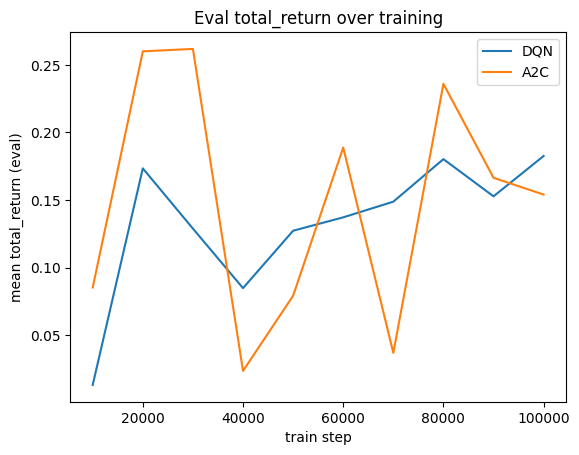

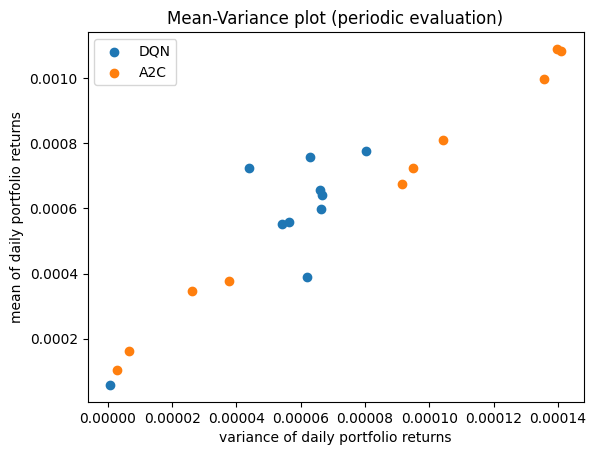

In [88]:
# 셀10: plots (DQN vs A2C)
import matplotlib.pyplot as plt

def plot_total_return_over_training(dqn_logs, a2c_logs):
    plt.figure()
    plt.plot([m["step"] for m in dqn_logs["eval"]], [m["total_return"] for m in dqn_logs["eval"]], label="DQN")
    plt.plot([m["step"] for m in a2c_logs["eval"]], [m["total_return"] for m in a2c_logs["eval"]], label="A2C")
    plt.xlabel("train step")
    plt.ylabel("mean total_return (eval)")
    plt.title("Eval total_return over training")
    plt.legend()
    plt.show()

def plot_mean_variance(dqn_logs, a2c_logs):
    plt.figure()
    plt.scatter([m["daily_return_var"] for m in dqn_logs["eval"]],
                [m["daily_return_mean"] for m in dqn_logs["eval"]],
                label="DQN")
    plt.scatter([m["daily_return_var"] for m in a2c_logs["eval"]],
                [m["daily_return_mean"] for m in a2c_logs["eval"]],
                label="A2C")
    plt.xlabel("variance of daily portfolio returns")
    plt.ylabel("mean of daily portfolio returns")
    plt.title("Mean-Variance plot (periodic evaluation)")
    plt.legend()
    plt.show()

plot_total_return_over_training(dqn_logs, a2c_logs)
plot_mean_variance(dqn_logs, a2c_logs)
